In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

max_features = 20000
embedding_dim = 128
sequence_length = 500

2023-09-16 16:45:02.842245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read csv training data

In [4]:
df = pd.read_csv('./data/gender_data.csv')
df

,full_name,gender
0,PHẠM THỊ YẾN NHI,female
1,NGUYỄN QUỐC KHA,male
2,NGUYỄN QUÝ,male
3,TRẦN QUANG THÀNH,male
4,ĐẶNG NHO TIẾN,male
...,...,...
3010,VÕ PHI YẾN,female
3011,MAI MINH VƯƠNG,male
3012,LÊ THANH BÌNH,male
3013,NGUYỄN THANH LÂM,male


In [5]:
full_name_list = df['full_name'].to_list()
full_name_list[0:10]

['PHẠM THỊ YẾN NHI',
 'NGUYỄN QUỐC KHA',
 'NGUYỄN QUÝ',
 'TRẦN QUANG THÀNH',
 'ĐẶNG NHO TIẾN',
 'NGUYỄN XUÂN ĐÍNH',
 'TRẦN THỊ PHƯƠNG HẠNH',
 'PHAN TRUNG HÒA',
 'CAO VĂN PHỤNG',
 'BẠY BUỜ']

# Train model

In [6]:
# Build vector
bi_vector = CountVectorizer(ngram_range=(1, 2), 
                            analyzer='word', 
                            min_df=1, 
                            max_features=5000,
                           lowercase=True)
bi_vector.fit_transform(full_name_list).toarray()
features = bi_vector.get_feature_names_out()

len(features), features[0:100]

(3862,
 array(['an', 'an phúc', 'anh', 'anh cương', 'anh duy', 'anh hoàng',
        'anh huy', 'anh hào', 'anh hòa', 'anh hùng', 'anh khang',
        'anh khoa', 'anh kiệt', 'anh phong', 'anh quang', 'anh thi',
        'anh thành', 'anh thái', 'anh thư', 'anh thằng', 'anh tuấn',
        'anh tài', 'anh tú', 'anh vũ', 'anh xuân', 'anh đào', 'ba', 'bi',
        'buờ', 'bàng', 'bàng thị', 'bành', 'bành ngôn', 'bá', 'bá cương',
        'bá cường', 'bá dự', 'bá hiền', 'bá huỳnh', 'bá kiên', 'bá lộc',
        'bá minh', 'bá ngọc', 'bá thiện', 'bá thành', 'bá thám',
        'bá thông', 'bá thọ', 'bá tiền', 'bá trường', 'bá tình', 'bá việt',
        'bá đặng', 'bách', 'bách thanh', 'bách tùng', 'báo', 'báo trang',
        'bé', 'bé diêm', 'bé gái', 'bé hiền', 'bé hồng', 'bé liên',
        'bé thoảng', 'bé thị', 'bé trúc', 'bé tư', 'bình', 'bình du',
        'bình liêu', 'bình yên', 'bích', 'bích chi', 'bích huyền',
        'bích huệ', 'bích hạnh', 'bích hồng', 'bích khôn', 'bích lan',
        

In [7]:
# Build features
def gender_features(name, bi_vector, features):
    t = bi_vector.transform([name]).toarray()
    return dict(zip(features, t[0]))

df['gender_feature'] = df.apply(lambda x: gender_features(x['full_name'], bi_vector, features), axis=1)

# Split data
df_train, df_test = train_test_split(df, random_state=0, test_size=.2)

train_set = df_train.apply(lambda x: (x['gender_feature'], x['gender']), axis=1).to_list()
test_set = df_test.apply(lambda x: (x['gender_feature'], x['gender']), axis=1).to_list()

X_train, y_train = [x[0] for x in train_set], [x[1] for x in train_set]
X_test, y_test = [x[0] for x in test_set], [x[1] for x in test_set]

len(train_set), len(test_set)

(2412, 603)

In [8]:
import nltk

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(train_set)

# output should be 'male'
print(nltk.classify.accuracy(classifier, train_set))
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(10)

print(classifier.classify(gender_features('phan thị cẩm hồng', bi_vector, features)))

0.986318407960199
0.9469320066334992
Most Informative Features
                     thị = 1              female : male   =    336.9 : 1.0
                  lê thị = 1              female : male   =     59.2 : 1.0
                     văn = 1                male : female =     58.3 : 1.0
                trần thị = 1              female : male   =     55.0 : 1.0
                     thu = 1              female : male   =     38.2 : 1.0
                   thành = 1                male : female =     30.1 : 1.0
                      mỹ = 1              female : male   =     26.7 : 1.0
                     kim = 1              female : male   =     23.5 : 1.0
                   trung = 1                male : female =     21.9 : 1.0
                     hữu = 1                male : female =     20.0 : 1.0
female


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, classifier.classify_many(X_test)))
print(confusion_matrix(y_test, classifier.classify_many(X_test)))

              precision    recall  f1-score   support

      female       0.96      0.94      0.95       308
        male       0.93      0.96      0.95       295

    accuracy                           0.95       603
   macro avg       0.95      0.95      0.95       603
weighted avg       0.95      0.95      0.95       603

[[288  20]
 [ 12 283]]


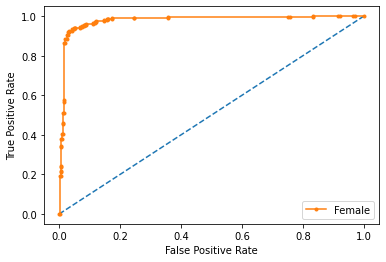

In [10]:
import numpy as np
from matplotlib import pyplot
from sklearn import metrics

yhat = classifier.prob_classify_many(X_test)
yprob = [x.prob('female') for x in yhat]
ydecode = [2 if x == 'female' else 1 for x in y_test]
fpr, tpr, thresholds = metrics.roc_curve(ydecode, yprob, pos_label=2)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='')
pyplot.plot(fpr, tpr, marker='.', label='Female')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [20]:
yhat = classifier.prob_classify_many(X_test)
yprob = [x.prob('female') for x in yhat]
ydecode = [1 if x == 'female' else 0 for x in y_test]
x = metrics.roc_auc_score(ydecode, yprob)
x

0.9779661016949153

# Improve accuracy by dropping lastname

We drop the last name because we thought last name will not affect the gender

In [36]:
full_name_list = df['full_name'].to_list()
last_name_list = [x.split(' ')[0] for x in full_name_list]
middle_first_name_list = [" ".join(x.split(' ')[1:]) for x in full_name_list]
middle_first_name_list[0:5]

['THỊ YẾN NHI', 'QUỐC KHA', 'QUÝ', 'QUANG THÀNH', 'NHO TIẾN']

In [37]:
# Build vector with middle and first name
bi_vector = CountVectorizer(ngram_range=(1, 2), 
                            analyzer='word', 
                            min_df=1, 
                            max_features=5000,
                           lowercase=True)
bi_vector.fit_transform(middle_first_name_list).toarray()
features = bi_vector.get_feature_names_out()
features

array(['an', 'an phúc', 'anh', ..., 'ạnh', 'ạnh tú', 'ẩn'], dtype=object)

In [56]:
def gender_features(name, bi_vector, features):
    
    # Split last name and middle and first name
    last_name = name.split(' ')[0]
    middle_first_name = " ".join(name.split(' ')[1:])
    
    t = bi_vector.transform([middle_first_name]).toarray()
    return dict(zip(features, t[0]))

df['gender_feature'] = df.apply(lambda x: gender_features(x['full_name'], bi_vector, features), axis=1)

# Split data
df_train, df_test = train_test_split(df, random_state=0, test_size=.2)

# train_set = df_train.apply(lambda x: (x['gender_feature'], x['gender']), axis=1).to_list()
# test_set = df_test.apply(lambda x: (x['gender_feature'], x['gender']), axis=1).to_list()

# X_train, y_train = [x[0] for x in train_set], [x[1] for x in train_set]
# X_test, y_test = [x[0] for x in test_set], [x[1] for x in test_set]

X_train, y_train = df_train['gender_feature'].to_list(), df_train['gender'].to_list()
X_test, y_test = df_test['gender_feature'].to_list(), df_test['gender'].to_list()

len(train_set), len(test_set)

(2412, 603)

In [57]:
import nltk

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(train_set)

# output should be 'male'
print(nltk.classify.accuracy(classifier, train_set))
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(10)

print(classifier.classify(gender_features('phan thị cẩm hồng', bi_vector, features)))

0.9821724709784412
0.9469320066334992
Most Informative Features
                     thị = 1              female : male   =    335.7 : 1.0
                     văn = 1                male : female =    136.1 : 1.0
                     thu = 1              female : male   =     38.2 : 1.0
                   thành = 1                male : female =     30.1 : 1.0
                      mỹ = 1              female : male   =     26.7 : 1.0
                     kim = 1              female : male   =     23.2 : 1.0
                   trung = 1                male : female =     21.9 : 1.0
                     hữu = 1                male : female =     20.0 : 1.0
                     mai = 1              female : male   =     17.0 : 1.0
                     cẩm = 1              female : male   =     16.5 : 1.0
female


/Users/truong.vu.1/opt/anaconda3/envs/general/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


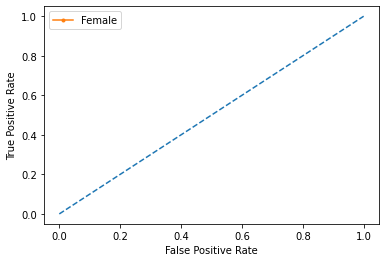

In [58]:
import numpy as np
from matplotlib import pyplot
from sklearn import metrics

yhat = classifier.prob_classify_many(X_test)
yprob = [x.prob('female') for x in yhat]
ydecode = [0 if x == 'female' else 1 for x in y_test]
fpr, tpr, thresholds = metrics.roc_curve(ydecode, yprob, pos_label=2)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='')
pyplot.plot(fpr, tpr, marker='.', label='Female')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [59]:
yhat = classifier.prob_classify_many(X_test)
yprob = [x.prob('female') for x in yhat]
ydecode = [1 if x == 'female' else 0 for x in y_test]
x = metrics.roc_auc_score(ydecode, yprob)
x

0.9774158045344485

The AUC with dropping the last name is not higher than without lastname. However, we still think dropping last name is better in case we do not have large samples of name to train and reduce the noise of model.

# Test with new data

In [60]:
df_test_new = pd.read_csv('./data/gender_data_2.csv')
df_test_new

,full_name,gender
0,Trương Huỳnh Xuân An,male
1,Đỗ Nguyễn Quốc Anh,male
2,Hoàng Ngọc Trâm Anh,female
3,Lê Ngọc Tuyết Anh,female
4,Phan Thị Tú Anh,female
...,...,...
1623,Phạm Duy Mạnh,male
1624,Hoàng Hoài male,male
1625,Trịnh Nhật Bách,male
1626,Bùi Đức Cường,male


In [43]:
df_test_new['gender_feature'] = df_test_new.apply(lambda x: gender_features(x['full_name'], 
                                                                            bi_vector, features), 
                                                  axis=1)

train_set = df_train.apply(lambda x: (x['gender_feature'], x['gender']), axis=1).to_list()
test_set = df_test.apply(lambda x: (x['gender_feature'], x['gender']), axis=1).to_list()

X_train, y_train = [x[0] for x in train_set], [x[1] for x in train_set]
X_test, y_test = [x[0] for x in test_set], [x[1] for x in test_set]

X_test = df_test_new['gender_feature'].to_list()

In [61]:
df_test_new['gender_feature'] = df_test_new.apply(lambda x: gender_features(x['full_name'], 
                                                                            bi_vector, features), 
                                                  axis=1)
X_test_new, y_test_new = df_test_new['gender_feature'].to_list(), df_test_new['gender'].to_list()

In [62]:
yhat = classifier.prob_classify_many(X_test_new)
yprob = [x.prob('female') for x in yhat]
ydecode = [1 if x == 'female' else 0 for x in y_test_new]
x = metrics.roc_auc_score(ydecode, yprob)
x

0.9788161073622187

# Backup

In [81]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Predict
# predict = classifier.classify_many(X_test)

# def match_predict(test, predict):
#     if predict == 'female' and test == predict:
#         return 1
#     elif predict == 'male' and test == predict:
#         return 2
#     elif predict == 'female' and test != predict:
#         return 3
#     elif predict == 'male' and test != predict:
#         return 4

# # Match
# match = [match_predict(v, predict[i])  for i, v in enumerate(y_test)]

# # Probability
# yhat = classifier.prob_classify_many(X_test)
# yprob = [x.prob('female') for x in yhat]

# xf1 = [yprob[i]  for i, v in enumerate(match) if v == 1]
# xm1 = [1 - yprob[i]  for i, v in enumerate(match) if v == 2]
# xf2 = [yprob[i]  for i, v in enumerate(match) if v == 3]
# xm2 = [1 - yprob[i]  for i, v in enumerate(match) if v == 4]

In [82]:
# # Plot
# kwargs = dict(alpha=0.5, bins=50)
# plt.hist(xf1, **kwargs, color='g', label='Female - Successful')
# plt.hist(xm1, **kwargs, color='g', label='Male - Successful')
# plt.hist(xf2, **kwargs, color='r', label='Female - Failed')
# plt.hist(xm2, **kwargs, color='b', label='Male - Failed')
# plt.gca().set(title='Frequency Histogram of probability distribution', ylabel='Frequency')
# #plt.xlim(50,75)
# plt.ylim(0,20)
# plt.legend();

In [83]:
# # thresholds 
# thresholds_male = [0.8, 0.85, 0.9, 0.95]
# thresholds_female = [0.8, 0.85, 0.9, 0.95]

# def calculate_accuracy(t_male, t_female, xf1, xm1, xf2, xm2):
#     xf1_t = [t for t in xf1 if t > t_female]
#     xf2_t = [t for t in xf2 if t > t_female]
#     xm1_t = [t for t in xm1 if t > t_male]
#     xm2_t = [t for t in xm2 if t > t_male]
    
#     return ((len(xf1_t) + len(xm1_t)) / (len(xf1_t) + len(xm1_t) + len(xf2_t) + len(xm2_t)), 
#             (len(xf1_t) + len(xm1_t) + len(xf2_t) + len(xm2_t)), 
#             (len(xf1_t) + len(xm1_t) + len(xf2_t) + len(xm2_t)) / (len(xf1) + len(xm1) + len(xf2) + len(xm2)))


# tbl_accuracy = [(im, ifm, calculate_accuracy(im, ifm, xf1, xm1, xf2, xm2)) for im in thresholds_male for ifm in thresholds_female]
# tbl_accuracy

In [84]:
# import numpy as np
# import matplotlib.pyplot as plt

# x = [kt[2][0] for kt in tbl_accuracy]
# y = [kt[2][1] for kt in tbl_accuracy]

# #fig, ax = plt.subplots()
# plt.scatter(x, y)
# ax = plt.gca()
# for i, kt in enumerate(tbl_accuracy):
#     ax.annotate(str(kt[0]) + ',' + str(kt[1]), (x[i], y[i]))
    
# plt.show()